In [1]:
import re
from operator import or_, and_, xor
from collections import defaultdict
from math import log2

In [2]:
with open('input_files/24.txt') as f:
    raw = f.read()
    wires, gates = raw.split('\n\n')
    wires = {k: int(v)  for (k, v) in (wire.split(': ') for wire in wires.split('\n'))}

    gates = [re.findall(r'(\w+) (\w+) (\w+) -> (\w+)', line)[0] for line in gates.split('\n')]
    
G = {c:(a, b, op) for a, op, b, c in gates}

In [3]:
def top_sort(gates, wires):
    '''topological sort of gates and wires'''
    s = set(wires)
    ordered = []

    while s:
        n = s.pop()

        ordered.append(n)
        for k, edges in gates.items():
            if n in edges:
                edges.remove(n)
                if len(edges) == 0:
                    s.add(k)      
    return ordered
    
def run_graph(G, wires, debug=False):

    wires = wires.copy()
    
    connection_graph = defaultdict(set)
    for k, (a, b, op) in G.items():
        connection_graph[k].update([a, b])
        
    order = top_sort(connection_graph, wires)

    ops = {
        'OR': or_,
        'AND': and_,
        'XOR': xor
    }
    
    for k in order:
        if k in wires:
            continue
        else: 
            a, b, op = G[k]
            wires[k] = ops[op](wires[a], wires[b])
    
    zs = sorted([(wire, value) for wire, value in wires.items() if wire.startswith('z')], reverse=True)
    xs = sorted([(wire, value) for wire, value in wires.items() if wire.startswith('x')], reverse=True)
    ys = sorted([(wire, value) for wire, value in wires.items() if wire.startswith('y')], reverse=True)

    xs = '0' + ''.join(str(n) for k, n in xs)
    ys = '0' + ''.join(str(n) for k, n in ys)
    zs = ''.join(str(n) for k, n in zs)

    if debug:
        return xs, ys, zs, wires
    else:
        return xs, ys, zs

G = {c:(a, b, op) for a, op, b, c in gates}

xs, ys, zs = run_graph(G, wires)
print("Part one:", int(zs, 2))

Part one: 46463754151024


### Part Two

This is a binary adder. It's broken. Not sure how to do this as a programming excercies, but it's solvable as an engineering problem.

In [4]:
G = {c:(a, b, op) for a, op, b, c in gates}

xs, ys, zs = run_graph(G, wires)

correct_sum = int(xs, 2) + int(ys, 2)
correct_bin = bin(correct_sum)[2:]

print(f"correct {bin(correct_sum)[2:]:>45}")
print(f"not: {zs:>49}")


correct 1010100011110111101111011100000010010001110000
not:    1010100100001000101111100011111010010001110000


### Identify bad bits
It's clear the problem starts with bit 15. Since this is an adder, changnig the gates contributing to bit 15 should not effect earlier bits but might change later ones. So fix from right to left.

In [5]:
def make_wire(x, y):
    '''
    Turn a decimal number into wires dict with  x00 - x44 & y00 - y44
    so they can be added
    '''
    length = 45
    binary_string = bin(x)[2:].zfill(length)[::-1]
    x =  {f'x{i:02}': int(bit) for i, bit in enumerate(binary_string)}
    binary_string = bin(y)[2:].zfill(length)[::-1]
    y =  {f'y{i:02}': int(bit) for i, bit in enumerate(binary_string)}
    
    return x | y

print("Incorrect addition of a single bit:")
for n in range(45):
    single_bit = make_wire(0, 2**n)
    xs, ys, zs = run_graph(G, single_bit)
    if int(zs, 2) != 2**n:
        print(f"{n}:",  zs)

print("Incorrect addition of multiple bits:")
for n in range(45):
    single_bit = make_wire(1, 2**n-1)
    xs, ys, zs = run_graph(G, single_bit)
    if int(zs, 2) != 2**n:
        print(f"{n}:",  zs)



Incorrect addition of a single bit:
15: 0000000000000000000000000000010000000000000000
21: 0000000000000000000000010000000000000000000000
30: 0000000000000010000000000000000000000000000000
34: 0000000000100000000000000000000000000000000000
Incorrect addition of multiple bits:
15: 0000000000000000000000000000010000000000000000
16: 0000000000000000000000000000001000000000000000
17: 0000000000000000000000000000011000000000000000
18: 0000000000000000000000000000111000000000000000
19: 0000000000000000000000000001111000000000000000
20: 0000000000000000000000000011111000000000000000
21: 0000000000000000000000000111111000000000000000
22: 0000000000000000000000010111111000000000000000
23: 0000000000000000000000100111111000000000000000
24: 0000000000000000000001000111111000000000000000
25: 0000000000000000000010000111111000000000000000
26: 0000000000000000000100000111111000000000000000
27: 0000000000000000001000000111111000000000000000
28: 0000000000000000010000000111111000000000000000
29: 00000

### Isolate the gates for a specific bit
Find all the parents in the graph contributing to a particular bit.
To isolate just thos contibuting to the broken bit, remove the parents of the earlier bit.

In [6]:
def find_parents(G, node):
    stack = [node]
    trace = set()
    while stack:
        key = stack.pop()
        trace.add(key)
        if key not in G:
            continue
        a, b, op = G[key]
        stack.append(a)
        stack.append(b)
    return trace

G = {c:(a, b, op) for a, op, b, c in gates}
parents_15 = find_parents(G, 'z15') - find_parents(G, 'z14')

for node in parents_15:
    print(node, G.get(node, node))

snp ('hhw', 'ccp', 'AND')
hhw ('x15', 'y15', 'XOR')
ccp ('gnp', 'qgm', 'OR')
z15 ('snp', 'mnh', 'OR')
qgm ('y14', 'x14', 'AND')
mnh ('x15', 'y15', 'AND')
gnp ('shm', 'kds', 'AND')
y15 y15
x15 x15


#### Good node

Good nodes all have the same structure, which is a [fuller adder](https://en.wikipedia.org/wiki/Adder_(electronics)#Full_adder) with 1 OR, 2, AND, and 2 XOR gates.

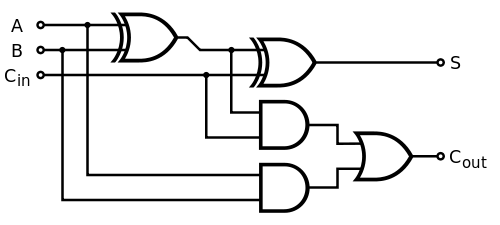

**We can see this in the good node below:**   
- 2 inputs entering an XOR (shm: y14, x14 XOR)
- The output coming from the second XOR (z14)
- AND gate taking inputs from previous node to the carry (vnf)
- etc.


In [7]:
parents_14 = find_parents(G, 'z14') - find_parents(G, 'z13')

for node in parents_14:
    print(node, G.get(node, node))

vnf ('x13', 'y13', 'AND')
kds ('vnf', 'wmm', 'OR')
y14 y14
wmm ('fpk', 'bkq', 'AND')
shm ('y14', 'x14', 'XOR')
z14 ('shm', 'kds', 'XOR')
x14 x14


#### Bad node at bit 15

The node outputting `z15` is broken, and we can see where by isolating it. z15 should be the output of an XOR gate combining the other XOR and the othre OR. 

Ultimatley we are only lloking for four pairs; we can search the input for gates with `hhw` as part of an XOR. There's only one.

```
ccp XOR hhw -> fph
```

Swapping this fixes this output:

In [8]:
parents_15 = find_parents(G, 'z15') - find_parents(G, 'z14')

for node in parents_15:
    print(node, G.get(node, node))

G = {c:(a, b, op) for a, op, b, c in gates}
G['fph'], G['z15'] = G['z15'], G['fph']

print("\nIncorrect addition of a single bit with change:")
for n in range(45):
    single_bit = make_wire(0, 2**n)
    xs, ys, zs = run_graph(G, single_bit)
    if int(zs, 2) != 2**n:
        print(f"{n}:",  zs)

snp ('hhw', 'ccp', 'AND')
hhw ('x15', 'y15', 'XOR')
ccp ('gnp', 'qgm', 'OR')
z15 ('snp', 'mnh', 'OR')
qgm ('y14', 'x14', 'AND')
mnh ('x15', 'y15', 'AND')
gnp ('shm', 'kds', 'AND')
y15 y15
x15 x15

Incorrect addition of a single bit with change:
21: 0000000000000000000000010000000000000000000000
30: 0000000000000010000000000000000000000000000000
34: 0000000000100000000000000000000000000000000000


#### Bad node at bit 21

This one is not as simple since the node is not connected to other nodes. We don't get the proper parent nodes. So we can look at the previous node and find how the carry bit should come over. In a correct bit, the carry comes over from the previous. Between 19 and 20 we see:

```
nsq ('mch', 'hwf', 'AND')
```

`mch` and `whf` come over from 19:  
`mch ('vsk', 'hpw', 'OR')`  
`hwf ('x19', 'y19', 'XOR')`  

Suggesting the broken node should be linked to 

```
sbs ('x20', 'y20', 'XOR')
fjh ('fcw', 'nsq', 'OR')
```

We can find that node and work backword to reassemble the node: 

```
fjh AND sbs -> pvq
pvq OR frw -> nsp
nsp XOR tqh -> gds  <-- this is our missing node
```

Swapping this fixes the second bit. Now just do this two more times:


In [9]:
G = {c:(a, b, op) for a, op, b, c in gates}
G['fph'], G['z15'] = G['z15'], G['fph']

parents_21 = find_parents(G, 'z21') - find_parents(G, 'z20')

print("Not much here to work with")
for node in parents_21:
    print(node, G.get(node, node))

print('\nPrevious node:')
parents_20 = find_parents(G, 'z20') - find_parents(G, 'z19')
for node in parents_20:
    print(node, G.get(node, node))

print('\nPrevious node parent:')
parents_19 = find_parents(G, 'z19') - find_parents(G, 'z18')
for node in parents_19:
    print(node, G.get(node, node))

G = {c:(a, b, op) for a, op, b, c in gates}
# Swapp both nodes
G['fph'], G['z15'] = G['z15'], G['fph']
G['gds'], G['z21'] = G['z21'], G['gds']

print("\nIncorrect addition of a single bit with change:")
for n in range(45):
    single_bit = make_wire(0, 2**n)
    xs, ys, zs = run_graph(G, single_bit)
    if int(zs, 2) != 2**n:
        print(f"{n}:",  zs)

Not much here to work with
z21 ('x21', 'y21', 'AND')
x21 x21
y21 y21

Previous node:
nsq ('mch', 'hwf', 'AND')
x20 x20
y20 y20
fcw ('x19', 'y19', 'AND')
sbs ('x20', 'y20', 'XOR')
fjh ('fcw', 'nsq', 'OR')
z20 ('fjh', 'sbs', 'XOR')

Previous node parent:
vsk ('sgs', 'qcf', 'AND')
mch ('vsk', 'hpw', 'OR')
z19 ('mch', 'hwf', 'XOR')
hwf ('x19', 'y19', 'XOR')
hpw ('x18', 'y18', 'AND')
y19 y19
x19 x19

Incorrect addition of a single bit with change:
30: 0000000000000010000000000000000000000000000000
34: 0000000000100000000000000000000000000000000000


### After all swaps:

No more incorrect bits:

In [10]:
G = {c:(a, b, op) for a, op, b, c in gates}
G['fph'], G['z15'] = G['z15'], G['fph']
G['gds'], G['z21'] = G['z21'], G['gds']
G['wrk'], G['jrs'] = G['jrs'], G['wrk']
G['cqk'], G['z34'] = G['z34'], G['cqk']

print("\nIncorrect addition of a single bit with change:")
for n in range(45):
    single_bit = make_wire(0, 2**n)
    xs, ys, zs = run_graph(G, single_bit)
    if int(zs, 2) != 2**n:
        print(f"{n}:",  zs)

print("Incorrect addition of multiple bits:")
for n in range(45):
    single_bit = make_wire(1, 2**n-1)
    xs, ys, zs = run_graph(G, single_bit)
    if int(zs, 2) != 2**n:
        print(f"{n}:",  zs)



Incorrect addition of a single bit with change:
Incorrect addition of multiple bits:


In [11]:
xs, ys, zs = run_graph(G, wires)

correct_sum = int(xs, 2) + int(ys, 2)
correct_bin = bin(correct_sum)[2:]

calculated_sum = int(zs, 2)

print(f"correct {bin(correct_sum)[2:]:>45}")
print(f"correct {zs:>45}")

correct_sum, calculated_sum

correct 1010100011110111101111011100000010010001110000
correct 1010100011110111101111011100000010010001110000


(46445498475632, 46445498475632)

In [1207]:
','.join(sorted(['cqk','fph','gds','jrs', 'wrk', 'z15', 'z21','z34']))

'cqk,fph,gds,jrs,wrk,z15,z21,z34'